## **Note**

In this notebook, i just prepare the data then fine tuning VGG16 to diagnosis pneumonia.
If you wanna see insight the dataset, please visit this notebook --->> https://www.kaggle.com/luukhang/build-alexnet-to-classifies-pneumonia

# 1. Import libs

In [1]:
# Common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Utils
from tqdm import tqdm
import datetime

# Sklearn
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, AveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print('Import successfully!')

Import successfully!


# 2. Prepare data

In [2]:
# Init variables
input_folder = '../input/coronahack-chest-xraydataset'
test_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')
train_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')
metadata_df = pd.read_csv(os.path.join(input_folder, 'Chest_xray_Corona_Metadata.csv'), index_col=0)

In [3]:
# Split to train & test set
train_df = metadata_df[metadata_df.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata_df[metadata_df.Dataset_type == 'TEST'].reset_index(drop=True)

# Check train_df size + test_df size == metadata_df size
assert train_df.size + test_df.size == metadata_df.size

print(f'Shape of train data: { train_df.shape }')
print(f'Shape of test data: { test_df.shape }')

train_df.sample(10)

Shape of train data: (5286, 5)
Shape of test data: (624, 5)


,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
3674,person447_virus_921_1.jpeg,Pnemonia,TRAIN,NaN,Virus
2289,person1507_bacteria_3943.jpeg,Pnemonia,TRAIN,NaN,bacteria
4687,person61_bacteria_290.jpeg,Pnemonia,TRAIN,NaN,bacteria
4938,person761_virus_1389.jpeg,Pnemonia,TRAIN,NaN,Virus
1832,person1170_virus_1969.jpeg,Pnemonia,TRAIN,NaN,Virus
3338,person27_bacteria_138.jpeg,Pnemonia,TRAIN,NaN,bacteria
196,IM-0394-0001.jpeg,Normal,TRAIN,NaN,NaN
2377,person1478_bacteria_3848.jpeg,Pnemonia,TRAIN,NaN,bacteria
2893,person26_bacteria_122.jpeg,Pnemonia,TRAIN,NaN,bacteria
2724,person1698_bacteria_4497.jpeg,Pnemonia,TRAIN,NaN,bacteria


In [4]:
# fill na
train_df.fillna('unknow', inplace=True)
test_df.fillna('unknow', inplace=True)

In [5]:
train_datagen = ImageDataGenerator(rotation_range=10,
                              brightness_range=(0.1, 1.2),
                              horizontal_flip=True,
                              zoom_range=[0.75, 1])
test_datagen = ImageDataGenerator()

In [6]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

In [7]:
train_batches = train_datagen.flow_from_dataframe(train_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

valid_batches = test_datagen.flow_from_dataframe(valid_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

test_batches = test_datagen.flow_from_dataframe(test_df,
                                            directory=test_img_folder,
                                            x_col='X_ray_image_name',
                                            y_col='Label',
                                            class_mode='binary',
                                            batch_size=8,
                                            shuffle=False)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [8]:
print(f'Label encode: { train_batches.class_indices }')

Label encode: {'Normal': 0, 'Pnemonia': 1}


In [9]:
train_batches_series = pd.Series(train_batches.classes)
valid_batches_series = pd.Series(valid_batches.classes)

print(f'Value count in train_batches: \n{ train_batches_series.value_counts() }')
print(f'Value count in valid_batches: \n{ valid_batches_series.value_counts() }')

Value count in train_batches: 
1    3169
0    1059
dtype: int64
Value count in valid_batches: 
1    775
0    283
dtype: int64


## 3. Fine tuning 

In [10]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
create_dir('models')

**Preprocessing layer**

In [11]:
resize_and_rescale = Sequential([
    Resizing(224, 224),
    Rescaling(1./255)
])

**Initialize metric**

In [12]:
metrics = [TruePositives(name='TP'),
           TrueNegatives(name='TN'),
           FalsePositives(name='FP'),
           FalseNegatives(name='FN'),
           AUC(curve='PR', name='AUC')]

In [13]:
pretrained_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='avg')

58892288/58889256 [==============================] - 0s 0us/step


In [14]:
# Preprocessing layer
ft_vgg16 = Sequential([resize_and_rescale])
# Feature extractor layer
ft_vgg16.add(pretrained_vgg16)
# Classifier layer
ft_vgg16.add(Dense(1, activation='sigmoid'))

In [15]:
# Freeze
#for layer in ft_vgg16.layers[:3]:
#    layer.trainable = False

In [16]:
model_dir = 'models/resnet16'
model_file = 'best_resnet16.hdf5'

create_dir(model_dir)

checkpoint = ModelCheckpoint(os.path.join(model_dir, model_file),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30,
                               verbose=1,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), 
                              patience=7, min_delta=1e-3, verbose=1, min_lr=1e-7)

In [17]:
# Initialize TensorBoard
log_dir = 'models/alexnet/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
epochs = 200
lr = 1e-4

ft_vgg16.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=metrics)

training_time_start = datetime.datetime.now()

vgg16_history = ft_vgg16.fit(train_batches,
                                epochs=epochs,
                                verbose=2,
                                callbacks=[checkpoint, reduce_lr, tensorboard_callback, early_stopping],
                                validation_data=valid_batches,
                                steps_per_epoch=len(train_batches),
                                validation_steps=len(valid_batches))

training_time_end = datetime.datetime.now()

Epoch 1/200
34/34 - 201s - loss: 0.5118 - TP: 3014.0000 - TN: 190.0000 - FP: 869.0000 - FN: 155.0000 - AUC: 0.8655 - val_loss: 0.2885 - val_TP: 748.0000 - val_TN: 172.0000 - val_FP: 111.0000 - val_FN: 27.0000 - val_AUC: 0.9854

Epoch 00001: val_loss improved from inf to 0.28850, saving model to models/resnet16/best_resnet16.hdf5
Epoch 2/200
34/34 - 135s - loss: 0.4339 - TP: 2924.0000 - TN: 467.0000 - FP: 592.0000 - FN: 245.0000 - AUC: 0.9267 - val_loss: 0.2523 - val_TP: 731.0000 - val_TN: 220.0000 - val_FP: 63.0000 - val_FN: 44.0000 - val_AUC: 0.9877

Epoch 00002: val_loss improved from 0.28850 to 0.25229, saving model to models/resnet16/best_resnet16.hdf5
Epoch 3/200
34/34 - 135s - loss: 0.2912 - TP: 2915.0000 - TN: 789.0000 - FP: 270.0000 - FN: 254.0000 - AUC: 0.9741 - val_loss: 0.2094 - val_TP: 736.0000 - val_TN: 225.0000 - val_FP: 58.0000 - val_FN: 39.0000 - val_AUC: 0.9891

Epoch 00003: val_loss improved from 0.25229 to 0.20940, saving model to models/resnet16/best_resnet16.hdf5
E

In [19]:
total_training_seconds = (training_time_end - training_time_start).seconds
print('Total training time: ', str(datetime.timedelta(seconds=total_training_seconds)))

Total training time:  2:31:38


## 4. Evaluate

In [20]:
vgg16_hist_df = pd.DataFrame(vgg16_history.history)

**Plot over entire epochs**

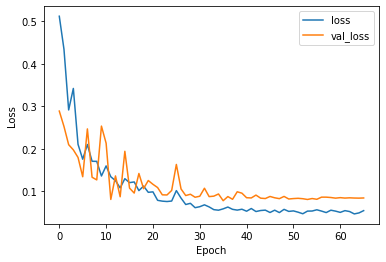

In [21]:
vgg16_hist_df.loc[:, ['loss', 'val_loss']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

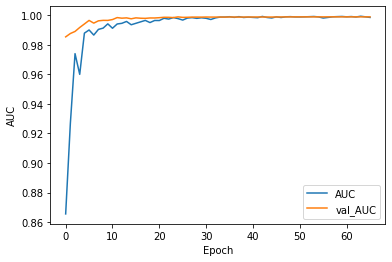

In [22]:
vgg16_hist_df.loc[:, ['AUC', 'val_AUC']].plot()
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.show()

**Plot over half first and first last epochs**

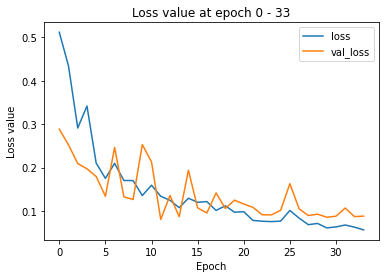

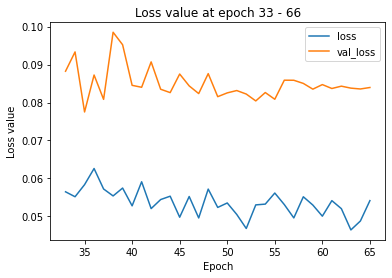

In [23]:
num_of_epochs = vgg16_hist_df.shape[0]
half_epoch = int(num_of_epochs / 2)

first_half_vgg16_hist = vgg16_hist_df.loc[:half_epoch]
first_title = f'Loss value at epoch 0 - { half_epoch }'

last_half_vgg16_hist = vgg16_hist_df.loc[half_epoch:len(vgg16_hist_df)]
last_title = f'Loss value at epoch { half_epoch } - { len(vgg16_hist_df) }'

hists = [first_half_vgg16_hist, last_half_vgg16_hist]
titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['loss', 'val_loss']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss value')
    ax.set_title(titles[i])
plt.show()

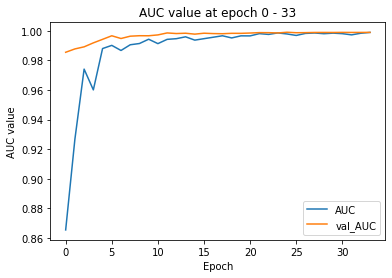

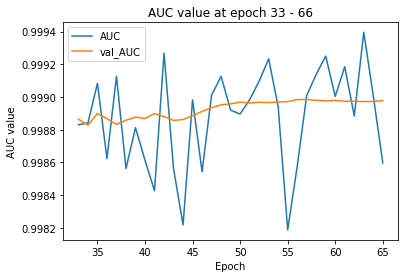

In [24]:
first_title = f'AUC value at epoch 0 - { half_epoch }'
last_title = f'AUC value at epoch { half_epoch } - { len(vgg16_hist_df) }'

titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['AUC', 'val_AUC']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC value')
    ax.set_title(titles[i])
plt.show()

In [25]:
evaluate_vgg16 = ft_vgg16.evaluate(test_batches, verbose=1)

78/78 [==============================] - 12s 140ms/step - loss: 0.1783 - TP: 385.0000 - TN: 204.0000 - FP: 30.0000 - FN: 5.0000 - AUC: 0.9884


In [26]:
loss, tp, tn, fp, fn, auc = evaluate_vgg16[0], evaluate_vgg16[1], evaluate_vgg16[2], evaluate_vgg16[3], evaluate_vgg16[4], evaluate_vgg16[5]
print(f'Test loss: { loss }')
print(f'True positive: { tp }')
print(f'True negative: { tn }')
print(f'False positive: { fp }')
print(f'False negative: { fn }')
print('AUC: %.2f' % auc)

Test loss: 0.17832344770431519
True positive: 385.0
True negative: 204.0
False positive: 30.0
False negative: 5.0
AUC: 0.99
